In [23]:
import pandas as pd
import random
import numpy as np
from numpy import linalg as LA


##################################################################################### COPULE DATA ###################################################################################

from scipy.io import arff
data = arff.loadarff('edm.arff')
df = pd.DataFrame(data[0])

covariables = df.iloc[:,0:16].values
response = df.iloc[:,16:18].values
positions = np.arange(154)

from sklearn.model_selection import train_test_split

covariables_train, covariables_test, response_train, response_test,positions_train,positions_test = train_test_split(covariables, response,positions, test_size=0.33, random_state=42)

####################################################################################################################################################################################
####################################################################################################################################################################################

#Pour le training, build training data
xtrain,ytrain = covariables_train, response_train

#Pour tester build test data
xtest,ytest = covariables_test, response_test 

In [11]:

#Pour tester build test data
#xtest,ytest = covariables_test, response_test 

Train_PottsData = xtrain

#Test_PottsData = xtest

q = 20
T =1000

sigma = 1

Initial_Spin_Configuration = []

for i in range(len(Train_PottsData)):
    
    Initial_Spin_Configuration.append(random.randint(1,q))


from collections import defaultdict
# function for adding edge to graph 
graph = defaultdict(list) 


# Python program to print connected  
# components in an undirected graph
#https://www.geeksforgeeks.org/connected-components-in-an-undirected-graph/
class Graph: 
      
    # init function to declare class variables 
    def __init__(self,V): 
        self.V = V 
        self.adj = [[] for i in range(V)] 
  
    def DFSUtil(self, temp, v, visited): 
  
        # Mark the current vertex as visited 
        visited[v] = True
  
        # Store the vertex to list 
        temp.append(v) 
  
        # Repeat for all vertices adjacent 
        # to this vertex v 
        for i in self.adj[v]: 
            if visited[i] == False: 
                  
                # Update the list 
                temp = self.DFSUtil(temp, i, visited) 
        return temp 
  
    # method to add an undirected edge 
    def addEdge(self, v, w): 
        self.adj[v].append(w) 
        self.adj[w].append(v) 
  
    # Method to retrieve connected components 
    # in an undirected graph 
    def connectedComponents(self): 
        visited = [] 
        cc = [] 
        for i in range(self.V): 
            visited.append(False) 
        for v in range(self.V): 
            if visited[v] == False: 
                temp = [] 
                cc.append(self.DFSUtil(temp, v, visited)) 
        return cc
    
# This code is contributed by Abhishek Valsan    


My_Potts_Graph = Graph(len(Train_PottsData))



from collections import OrderedDict

def findneighbors(i, Train_PottsData, Initial_Spin_Configuration, k_voisins = 10):
    
    Compute_Norms  = {}
    
    for j in range(len(Train_PottsData)):
        
        bond_ij_proba = 1 - np.exp(-(1/T)*(LA.norm(Train_PottsData[i,:] - Train_PottsData[j,:]))/(sigma))
        
        bond_ij = np.random.binomial(size=1, n=1, p=bond_ij_proba) 
        
        if (i != j and Initial_Spin_Configuration[i] == Initial_Spin_Configuration[j] and bond_ij[0]==1 ):
            
            Compute_Norms[j] = LA.norm(Train_PottsData[i,:] - Train_PottsData[j,:])
                                       

    OrderedCompute_Norms = OrderedDict(sorted(Compute_Norms.items(), key=lambda x: x[1]))

    OCN_size  = len(OrderedCompute_Norms)
    
    SelectedOrderedCompute_Norms = list(OrderedCompute_Norms)#[(OCN_size -k_voisins):OCN_size ]
                                       
    return SelectedOrderedCompute_Norms      


for i in range(len(Train_PottsData)):
    
    #let's get the top neighbors of observation i
    
    Selected_Neighbors = findneighbors(i, Train_PottsData, Initial_Spin_Configuration, k_voisins = 1)
    
    for j in Selected_Neighbors:
        
        #addEdge(graph,i,j)
        My_Potts_Graph.addEdge(i,j)


Potts_Clusters = My_Potts_Graph.connectedComponents() 

print(Potts_Clusters, "DONE")


def Compute_Partition (Train_PottsData, _Spin_Configuration, T=1, sigma=1):
    
    
    """ 
    
    Given the Data and Spin Configuration, this function compute the Partition
    
    Parameters : 
    ----------
    
    PottsData: the features data, X
    
    Initial_Spin_Configuration : Initial Spin configuration for all observations
    
    T : The temperature 
    
    sigma : The bandwitch
    
    """
    
    _My_Potts_Graph = Graph(len(Train_PottsData))
    
    for i in range(len(Train_PottsData)):
        #let's get the top neighbors of observation i

        Selected_Neighbors = findneighbors(i, Train_PottsData, _Spin_Configuration, k_voisins = 1)

        for j in Selected_Neighbors:

            #addEdge(graph,i,j)
            _My_Potts_Graph.addEdge(i,j)

                
    _Potts_Clusters = _My_Potts_Graph.connectedComponents() 
    
    return _Potts_Clusters

def Partitions_Clusters_Adjustments (New_Partition, Min_Cluster_Size):
    
    Copy_New_Partition = New_Partition.copy()
    
    List_of_clusters_size = [len(cluster)>Min_Cluster_Size for cluster in New_Partition]
    
    Somme_List_of_clusters_size = np.sum(List_of_clusters_size)
    
    
    if len(List_of_clusters_size)>0 and len(Copy_New_Partition)> Somme_List_of_clusters_size: 
        
        Position_Cluster_To_be_adjusted = List_of_clusters_size.index(0) 
        
        
        
    
    
    return adjusted_Partition


###Some supplementaries Code to adjust the clustering

import numpy as np
from numpy import linalg as LA

def ChangePartition(Partition, min_size):

    MyPartition = Partition.copy()
    
    max_iter = len(MyPartition)
    
    SearchCluster = [len(Cluster) > min_size for Cluster in MyPartition]
    
    if 0 in SearchCluster:
        ChooseTheFirstCluster = SearchCluster.index(0)

        distancelist = []
        
        for _i in range(max_iter):
                
                if _i!= ChooseTheFirstCluster:
                
                   distancelist.append(compute_distance(MyPartition[_i],MyPartition[ChooseTheFirstCluster]))
        
                else:
                     distancelist.append(0)   
                                       
        distancelist[ChooseTheFirstCluster] =  np.sum(distancelist)
                                       
        Cluster_To_MergeWith = np.argmin(distancelist)
                                       
        MyPartition[Cluster_To_MergeWith] = MyPartition[Cluster_To_MergeWith]+MyPartition[ChooseTheFirstCluster]
                                       
        del MyPartition[ChooseTheFirstCluster]
                                       
    return MyPartition                                   

def compute_distance(cluster1,cluster2):

    cluster_1 = cluster1.copy()
    cluster_2 = cluster2.copy()
    
    
    all_distances= []
    
    
    for j in cluster_1:
        
        all_distances.extend([LA.norm(Train_PottsData[j,:] - Train_PottsData[k,:]) for k in cluster_2])
        
        
    return float(np.min(all_distances))

def AdjustPartition(GeneratedPartition, min_cluster_size):
    
    NewPartition0 = GeneratedPartition

    NewPartition1 = ChangePartition(GeneratedPartition, 1)


    while NewPartition1 != NewPartition0:

          NewPartition0 = NewPartition1
            
          #Nous souhaitons ajuster les partitions à une taille de cluster minimum==5  
          NewPartitionAdj = ChangePartition(NewPartition0, min_cluster_size) 

          NewPartition1 = NewPartitionAdj

    return NewPartition1

###########
def Potts_Random_Partition (Train_PottsData, Initial_Partition = Potts_Clusters, Number_of_Random_Partitions = 1000) : 
    
    
    """ 
    
    This function generates _Random_Partitions for a given initial Potts_Clusters
    
    Parameters
    ----------
    
    Initial_Partition : A given initial (random partition) in defaultdict(list) format
    
    Number_of_Random_Partitions: Number of expected random partitions, must be greater than 0 preferably
    
    
    Return    
    ------
    
    Full_Observations_Spin_Configuration : A full list of spin configuration for each generated partition 
    
    Full_Partition_Sets : A full list of all generated partitions
    
    
    """
    
    Full_Observations_Spin_Configuration = defaultdict(list) 
    
    Full_Partition_Sets = defaultdict(list) 
    
    Actual_Partition = Initial_Partition
    
    k = 0
    
    while k < (Number_of_Random_Partitions + 1):
        
        
            #Create the Clustter Component spin configuration 

            _Cluster_Spin_Configuration = []

            for h in range(len(Actual_Partition)):

                _Cluster_Spin_Configuration.append(random.randint(1,q))

            #Find observation spin configuration

            Observations_Spin_Configuration = []

            for observation in range(len(Train_PottsData)):

                Observation_Cluster_index = [ int(observation in Cluster) for Cluster in  Actual_Partition ].index(1)

                Observations_Spin_Configuration.append(_Cluster_Spin_Configuration[Observation_Cluster_index])
            
            
            Full_Observations_Spin_Configuration[k] = Observations_Spin_Configuration
            
            
            New_Partition = Compute_Partition (Train_PottsData, Observations_Spin_Configuration, T=1, sigma=1)

            #print(New_Partition)
            
            AdjustedPartition = AdjustPartition(New_Partition,2)
            
            List_of_clusters_size = [len(cluster) for cluster in AdjustedPartition]
            
            if  int(np.min(List_of_clusters_size)) >= 1 : 
                
                                
                Full_Partition_Sets[k] = AdjustedPartition

                k = k + 1
                print("We are at step: %i"%k)
                print("Clusters Size of Current Partition", List_of_clusters_size)
                print("Partition is:", AdjustedPartition)
            Actual_Partition = AdjustedPartition
            
    return Full_Partition_Sets, Full_Observations_Spin_Configuration


import time
start_time = time.time()

NRP = 50

Partitions_Sets,Spin_Configuration_Sets = Potts_Random_Partition (Train_PottsData, Initial_Partition= Potts_Clusters, Number_of_Random_Partitions = NRP)

print("%i Partitions generated-- %s seconds ---DONE!" % (NRP, time.time() - start_time))

import pickle
output = open('edm_50_Partitions_constraints_2_Sets.pkl', 'wb')
pickle.dump(Partitions_Sets, output)
output.close()


[[0], [1], [2], [3], [4], [5, 16], [6], [7], [8], [9], [10], [11], [12], [13], [14, 22], [15], [17], [18], [19], [20], [21], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99], [100], [101], [102]] DONE
We are at step: 1
Clusters Size of Current Partition [7, 10, 3, 4, 4, 7, 4, 10, 3, 4, 5, 3, 3, 8, 3, 4, 3, 5, 6, 3, 4]
Partition is: [[26, 0, 9, 66, 74, 33, 86], [30, 27, 1, 36, 59, 37, 64, 94, 29, 97], [38, 10, 21], [39, 18, 25, 49], [50, 35, 47, 48], [52, 3, 24, 32, 34, 82, 93], [53, 51, 23, 83], [55, 5, 15, 17, 40, 56, 4, 61, 22, 100], [60, 13, 16], [63, 80, 46, 78], [69, 6, 7, 45,

We are at step: 15
Clusters Size of Current Partition [6, 7, 3, 3, 4, 4, 7, 3, 10, 3, 6, 3, 8, 3, 4, 3, 5, 5, 5, 4, 3, 4]
Partition is: [[19, 37, 11, 59, 64, 76], [26, 0, 9, 66, 74, 33, 86], [27, 83, 1], [38, 10, 21], [39, 18, 25, 49], [50, 35, 47, 48], [52, 3, 24, 32, 34, 82, 93], [53, 51, 23], [55, 5, 15, 17, 40, 56, 4, 61, 22, 100], [60, 13, 16], [69, 6, 7, 45, 80, 89], [77, 58, 73], [79, 62, 14, 71, 92, 68, 98, 12], [84, 72, 57], [85, 44, 41, 99], [87, 67, 8], [88, 42, 28, 65, 75], [91, 31, 70, 81, 20], [94, 29, 30, 36, 97], [95, 63, 46, 78], [101, 43, 2], [102, 90, 54, 96]]
We are at step: 16
Clusters Size of Current Partition [7, 10, 3, 4, 4, 7, 4, 10, 3, 6, 3, 3, 8, 3, 4, 3, 5, 5, 4, 3, 4]
Partition is: [[26, 0, 9, 66, 74, 33, 86], [30, 27, 1, 36, 59, 37, 64, 94, 29, 97], [38, 10, 21], [39, 18, 25, 49], [50, 35, 47, 48], [52, 3, 24, 32, 34, 82, 93], [53, 51, 23, 83], [55, 5, 15, 17, 40, 56, 4, 61, 22, 100], [60, 13, 16], [69, 6, 7, 45, 80, 89], [76, 19, 11], [77, 58, 73], [79, 6

We are at step: 30
Clusters Size of Current Partition [7, 10, 3, 4, 4, 7, 4, 10, 3, 6, 3, 3, 8, 3, 4, 3, 5, 5, 4, 3, 4]
Partition is: [[26, 0, 9, 66, 74, 33, 86], [30, 27, 1, 36, 59, 37, 64, 94, 29, 97], [38, 10, 21], [39, 18, 25, 49], [50, 35, 47, 48], [52, 3, 24, 32, 34, 82, 93], [53, 51, 23, 83], [55, 5, 15, 17, 40, 56, 4, 61, 22, 100], [60, 13, 16], [69, 6, 7, 45, 80, 89], [76, 19, 11], [77, 58, 73], [79, 62, 14, 71, 92, 68, 98, 12], [84, 72, 57], [85, 44, 41, 99], [87, 67, 8], [88, 42, 28, 65, 75], [91, 31, 70, 81, 20], [95, 63, 46, 78], [101, 43, 2], [102, 90, 54, 96]]
We are at step: 31
Clusters Size of Current Partition [7, 10, 3, 6, 7, 4, 12, 3, 6, 3, 3, 8, 3, 4, 3, 5, 5, 4, 3, 4]
Partition is: [[26, 0, 9, 66, 74, 33, 86], [30, 27, 1, 36, 59, 37, 64, 94, 29, 97], [38, 10, 21], [50, 35, 39, 18, 47, 48], [52, 3, 24, 32, 34, 82, 93], [53, 51, 23, 83], [55, 5, 15, 17, 25, 100, 40, 49, 56, 4, 61, 22], [60, 13, 16], [69, 6, 7, 45, 80, 89], [76, 19, 11], [77, 58, 73], [79, 62, 14, 71

We are at step: 45
Clusters Size of Current Partition [7, 10, 3, 4, 4, 7, 4, 10, 3, 6, 3, 3, 8, 3, 4, 3, 5, 5, 4, 3, 4]
Partition is: [[26, 0, 9, 66, 74, 33, 86], [30, 27, 1, 36, 59, 37, 64, 94, 29, 97], [38, 10, 21], [39, 18, 25, 49], [50, 35, 47, 48], [52, 3, 24, 32, 34, 82, 93], [53, 51, 23, 83], [55, 5, 15, 17, 40, 56, 4, 61, 22, 100], [60, 13, 16], [69, 6, 7, 45, 80, 89], [76, 19, 11], [77, 58, 73], [79, 62, 14, 71, 92, 68, 98, 12], [84, 72, 57], [85, 44, 41, 99], [87, 67, 8], [88, 42, 28, 65, 75], [91, 31, 70, 81, 20], [95, 63, 46, 78], [101, 43, 2], [102, 90, 54, 96]]
We are at step: 46
Clusters Size of Current Partition [7, 10, 3, 4, 4, 7, 4, 10, 3, 6, 3, 3, 8, 3, 4, 3, 3, 6, 5, 4, 3]
Partition is: [[26, 0, 9, 66, 74, 33, 86], [30, 27, 1, 36, 59, 37, 64, 94, 29, 97], [38, 10, 21], [39, 18, 25, 49], [50, 35, 47, 48], [52, 3, 24, 32, 34, 82, 93], [53, 51, 23, 83], [55, 5, 15, 17, 40, 56, 4, 61, 22, 100], [60, 13, 16], [69, 6, 7, 45, 80, 89], [76, 19, 11], [77, 58, 73], [79, 62, 1

In [3]:
def Partitions_Statistics (Partitions_Sets):
    
    #copy the partitions
    Partitions_sets_copy = Partitions_Sets.copy()
    
    # Number of data per cluster (NumbDC)
    NumbDC = []
    
    #Number of cluster per partition (NumbCPar)
    NumbCPar = []
    
    
    for k,partition in Partitions_sets_copy.items():
        
        clusters_size = List_of_clusters_size = [len(cluster) for cluster in partition]
        
        NumbDC.extend(clusters_size)
        
        NumbCPar.append(len(clusters_size))
        
    return    NumbDC, NumbCPar

In [12]:
NumbDC, NumbCPar = Partitions_Statistics (Partitions_Sets)

In [13]:
len(NumbDC)

1068

In [14]:
np.mean(NumbDC)

4.918539325842697

In [42]:
np.mean(NumbCPar)

1.3564356435643565

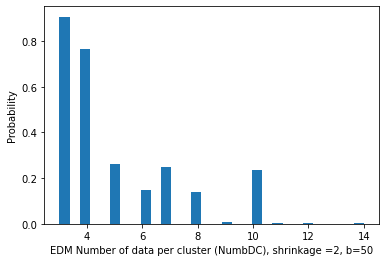

In [16]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(42)
plt.hist(NumbDC, density=True, bins=30)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('EDM Number of data per cluster (NumbDC), shrinkage =2, b=50');

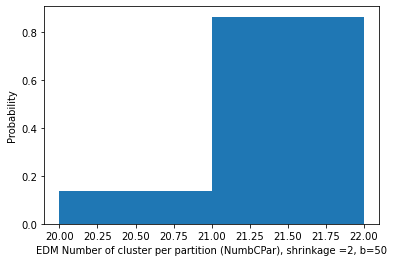

In [22]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(42)
plt.hist(NumbCPar
         , density=True, bins=2)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('EDM Number of cluster per partition (NumbCPar), shrinkage =2, b=50');

In [24]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import RandomForestRegressor

In [25]:

############################################################
regressor = RandomForestRegressor(n_estimators = 10, max_depth=30, random_state = 0)
regressor.fit(covariables_train,response_train) 

# Predict the model 
rftestpred = regressor.predict(covariables_test) 
# Predict the model 
rftrainpred = regressor.predict(covariables_train)  
# xgboost test RMSE Computation 
rftestrmse = MSE(response_test, rftestpred) 
print("test xgboost MSE : % f" %(rftestrmse))

# xgboost test RMSE Computation 
rftrainrmse = MSE(response_train, rftrainpred)
print("train xgboost MSE : % f" %(rftrainrmse))


test xgboost MSE :  0.140098
train xgboost MSE :  0.032330


In [26]:

############################################################
regressor = RandomForestRegressor(n_estimators = 5, max_depth=10, random_state = 0)
regressor.fit(covariables_train,response_train) 

# Predict the model 
rftestpred = regressor.predict(covariables_test) 
# Predict the model 
rftrainpred = regressor.predict(covariables_train)  
# xgboost test RMSE Computation 
rftestrmse = MSE(response_test, rftestpred)
print("test xgboost MSE : % f" %(rftestrmse))

# xgboost test RMSE Computation 
rftrainrmse = MSE(response_train, rftrainpred)
print("train xgboost MSE : % f" %(rftrainrmse))

test xgboost MSE :  0.185882
train xgboost MSE :  0.043689
